# Decision Trees:  Front to Back


### Lesson Objectives
- Describe the detailed process of decision trees
- Review: Understand how gini or entropy can be used to determine **information gain**
- Understand bias / variance tradeoff of decision trees
  - Why decision trees are prone to high variance
- Basic `sklearn` implemenation

In [1]:
%matplotlib inline
%autocall 1

import pandas as pd, numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex, Image

Automatic calling is: Smart


# Decision Trees Step by Step

### 1. Root node.  The root note receives the entire training set.
> _Each node represents a boolean condition on some set of the features._

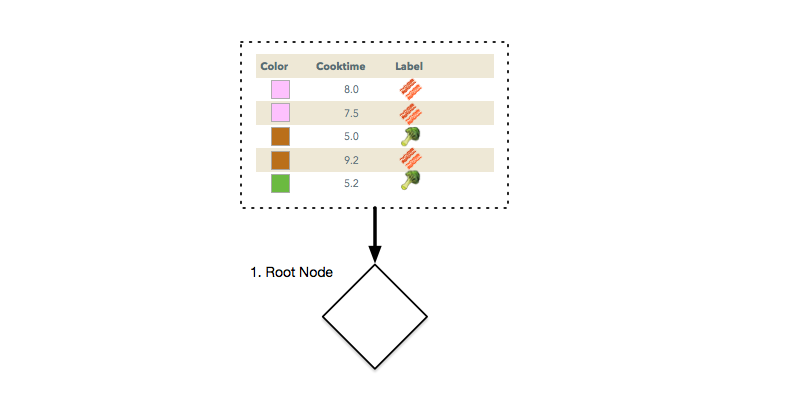

### 2. The result of each node splits the data into two subsets based on some condition
* The subsets are past to two child nodes, added to the tree with the objective to create the purest nodes in terms of label differentiation.
* For nodes that are unpure, we choose conditions to continue to split, grow our tree, that can further differentiate our data.

> A subset is considered "pure" when all members belong to the same class.

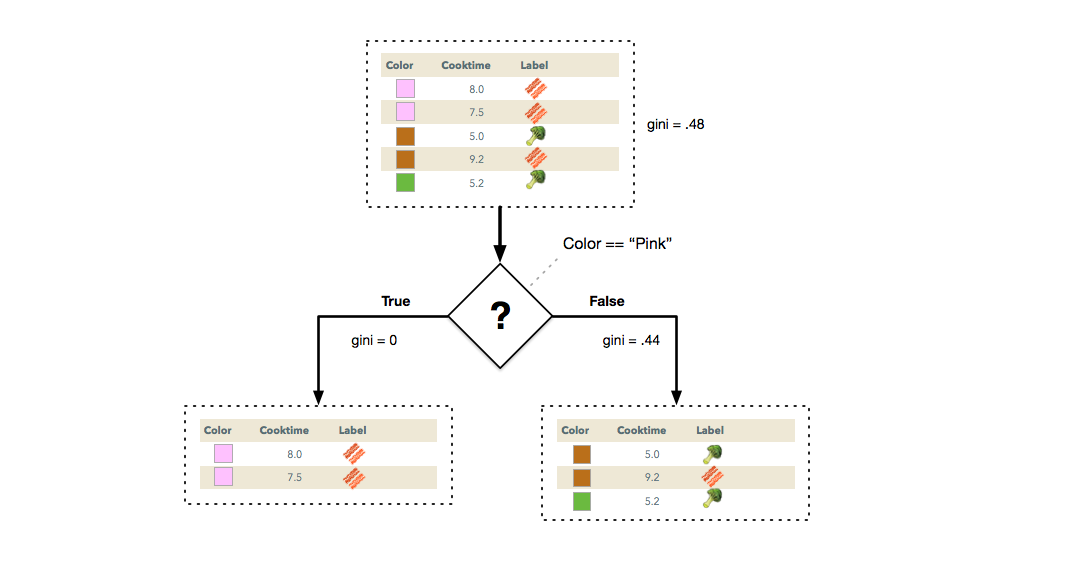

#### Does it matter which order we ask our questions or assert the condtions for splitting our nodes?

We use the idea of gini or entropy to measure how effective a given condition can differentiate specific subset of data through the idea of "purity".  Ideally, we decision trees split data with the goal of creating pure distributions of each class, through the splitting of data into child nodes, given specific conditions.  The process of achieving "purity" can also be though of as the process of elimination of uncertainly of a given class / subset / condition combination.

The condition with the highest _information gain_ reduces uncertainly of subset / class distributions the most, at each node.

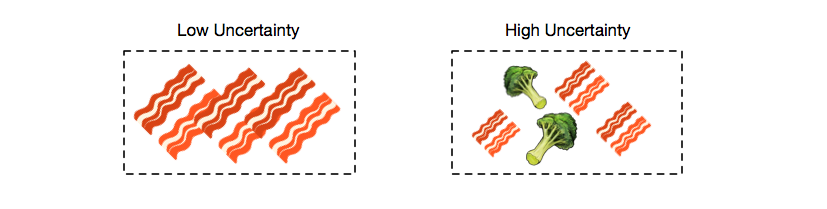

## Review: Information Gain

**Information gain** is a way for us to figure out how much information is contained within the resulting X from $ P(y\ |\ X\ =\ condition) $.

 ($H$ = entropy or gini):

## $$ H(parent) - [\text{Weighted Average}] * H(children) $$

Slightly more formally:

## $$ \Delta = H(\text{parent}) - \sum_{\text{children}}\frac{N_j}{N}H(\text{child}_j) $$

IG closer to 1 is desirable, unlike Gini or Entropy on its own.  IG is the weighed sum of either Gini or Entropy of all conditions for a node.


$H$ can be Gini or Entropy but we can use this to understand the overall information gain from parent to children.  If we wanted to see the first calculated gain for our first node, we could use the following example (which I know looks like a lot but we'll focus on a few elements to see how we can relate this idea of "best decision").

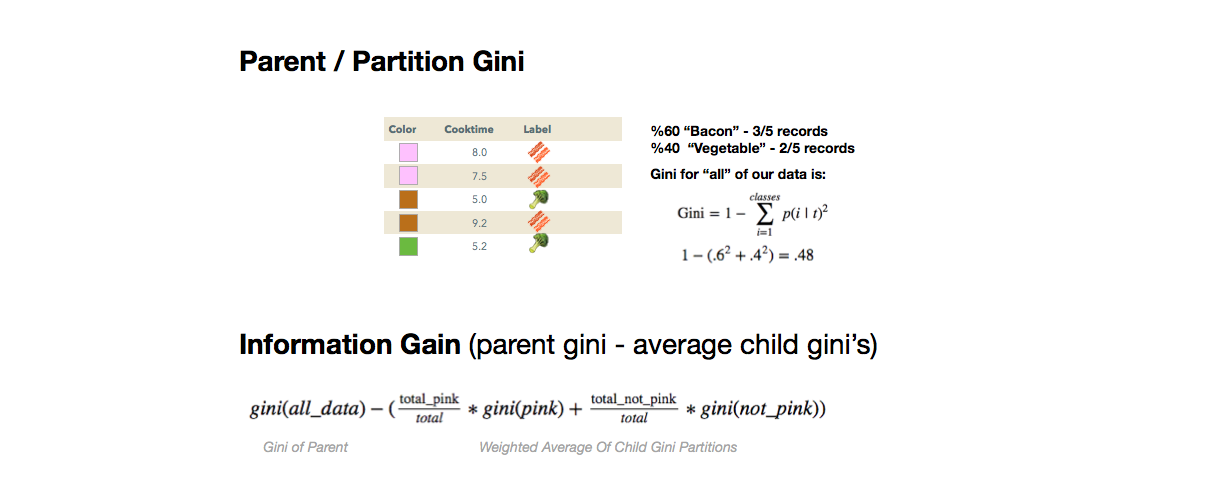

## A Completed Tree
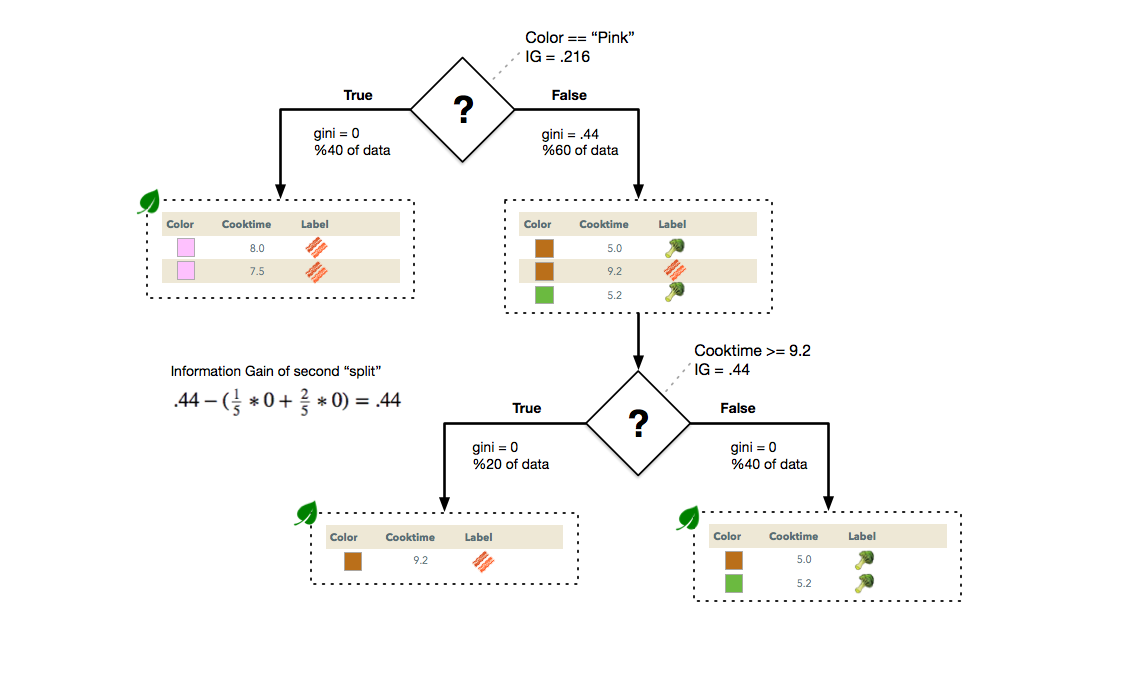

### Notice we snuck in some leaf nodes.  Notice anything interesting about them?

### Follow up:  What do you think of any reasons a leaf node may not be homogenous?

## Examining our Decision Tree Process (the hard way)

From here we will look at some of the low level processes that define how a decision tree is built, including:

- Conditional searching (which questions should we ask?)
- Splitting criterion 
- Information gain

The following procedural code will help us examine our basic tree based having 2 splits, based on the concept of vegetables and bacon and their cooking times.

In [2]:
def entropy(class_probabilities):
    # The sum of: inverse class probability 
    # scaled by probability of log base 2
    return np.sum(
        -class_p * np.log2(class_p) 
        for class_p in class_probabilities
            if class_p # no zero probabilities
    )

In [3]:
def gini(p):
    
    zero_conditions = (
        (p[0] == 0 and p[1] == 0),
        (p[0] == 1 and p[1] == 0),
        (p[0] == 0 and p[1] == 1),
    )
    
    if any(zero_conditions):
        return 0
    
    return 1 - np.sum(
        class_p**2
        for class_p in p
            if class_p # ignore zero probabilities
    )

In [4]:
data = [(0, 'Pink', '8', 'Bacon'), (1, 'Pink', '7.5', 'Bacon'),
           (2, 'Brown', '5', 'Vegetable'), (3, 'Brown', '9.2', 'Bacon'),
           (4, 'Green', '7.5', 'Vegetable')]

food = pd.DataFrame(data, columns=["index","Color", "Cooktime", "Label"])
food = food.set_index("index")
food

,Color,Cooktime,Label
index,,,
0,Pink,8,Bacon
1,Pink,7.5,Bacon
2,Brown,5,Vegetable
3,Brown,9.2,Bacon
4,Green,7.5,Vegetable


In [5]:
import pandas as pd, numpy as np

raw_data = """
Color	Cooktime	Label
Pink	8	Bacon
Pink	7.5	Bacon
Brown	5	Vegetable
Brown	9.2	Bacon
Green	7.5	Vegetable
"""

data = [row.split("\t") for row in raw_data.split("\n") if row != '']
food = pd.DataFrame(data[1:], columns=data[0])

food['Cooktime'] = food['Cooktime'].astype('float')
food.info()

food.to_records()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
Color       5 non-null object
Cooktime    5 non-null float64
Label       5 non-null object
dtypes: float64(1), object(2)
memory usage: 200.0+ bytes


rec.array([(0, 'Pink',  8. , 'Bacon'), (1, 'Pink',  7.5, 'Bacon'),
           (2, 'Brown',  5. , 'Vegetable'), (3, 'Brown',  9.2, 'Bacon'),
           (4, 'Green',  7.5, 'Vegetable')], 
          dtype=[('index', '<i8'), ('Color', 'O'), ('Cooktime', '<f8'), ('Label', 'O')])

In [6]:
def class_balance(dataframe, labels=["Bacon", "Vegetable"]):
    return [dataframe.query("Label == '%s'" % label).shape[0] / dataframe.shape[0]
            if dataframe.query("Label == '%s'" % label).shape[0] != 0 ## avoids division by 0
            else 0.0
            for label in labels]

def information_gain(current_uncertainty, gini_left, gini_right, left_pct, right_pct):
    
    weighted_average = (left_pct * gini_left) + (right_pct * gini_right)

    return current_uncertainty - weighted_average

def partition_condition(dataframe, condition):
    
    total = dataframe.shape[0]
    
    left        =  dataframe.query(condition)
    right       =  dataframe[~dataframe.index.isin(left.index)]
    left_total  =  left.shape[0] 
    right_total =  right.shape[0]
    
    left_balance, right_balance = class_balance(left), class_balance(right)
    
    return left_balance, right_balance, left_total, right_total

# We find the split that gives us the best information gain
conditions = [
    "Color == 'Pink'",
    "Color == 'Brown'",
    "Color == 'Green'",
    "Cooktime >= 5.0",
    "Cooktime >= 5.2",
    "Cooktime >= 7.5",
    "Cooktime >= 8.0",
    "Cooktime >= 9.2",
]

## Class balance of all the data
total        = food.shape[0]
class_pct    = class_balance(food)
current_gini = gini(class_pct)

print("Parent class balance:", class_pct)
print("Parent gini: ", current_gini)

## Check IG of all candidate split conditions
candidates = []
for condition in conditions:
    
    # left == records where condition is True, right == records where condition is False
    left_pct, right_pct, left_total, right_total = partition_condition(food, condition)
    left_gini, right_gini = gini(left_pct), gini(right_pct)
    
    gain = information_gain(current_gini, left_gini, right_gini, left_total / total, right_total / total)
    
    candidates.append({
        "condition": condition, 
        "gain": gain, 
        "left_gini": left_gini, 
        "left_pct": left_pct,
        "left_total": left_total,
        "right_gini": right_gini,
        "right_pct": right_pct,
        "right_total": right_total,
        "parent_records": total
    })

candidates = pd.DataFrame(candidates)
# candidates.sort_values("gain", ascending=False)
candidates

Parent class balance: [0.6, 0.4]
Parent gini:  0.48


,condition,gain,left_gini,left_pct,left_total,parent_records,right_gini,right_pct,right_total
0,Color == 'Pink',0.213333,0.000,"[1.0, 0.0]",2,5,0.444444,"[0.3333333333333333, 0.6666666666666666]",3
1,Color == 'Brown',0.013333,0.500,"[0.5, 0.5]",2,5,0.444444,"[0.6666666666666666, 0.3333333333333333]",3
2,Color == 'Green',0.180000,0.000,"[0.0, 1.0]",1,5,0.375000,"[0.75, 0.25]",4
3,Cooktime >= 5.0,0.000000,0.480,"[0.6, 0.4]",5,5,0.000000,"[0.0, 0.0]",0
4,Cooktime >= 5.2,0.180000,0.375,"[0.75, 0.25]",4,5,0.000000,"[0.0, 1.0]",1
5,Cooktime >= 7.5,0.180000,0.375,"[0.75, 0.25]",4,5,0.000000,"[0.0, 1.0]",1
6,Cooktime >= 8.0,0.213333,0.000,"[1.0, 0.0]",2,5,0.444444,"[0.3333333333333333, 0.6666666666666666]",3
7,Cooktime >= 9.2,0.080000,0.000,"[1.0, 0.0]",1,5,0.500000,"[0.5, 0.5]",4


### Let's check out how we can split our right most node (Color != "Pink")

If you recall, the right most node sends all the data that isn't "Pink", which consists of exactly 3 rows, hiding 1 bacon and 2 vegatable records.  We will rescue our bacon not to worry!

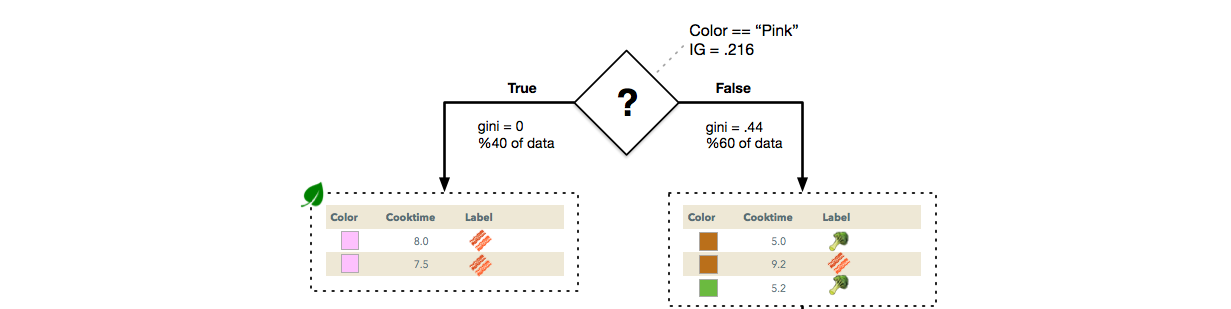

In [7]:
# We find the split that gives us the best information gain
conditions = [
    # "Color == 'Pink'", ## We used this one at our root node!
    "Color == 'Brown'",
    "Color == 'Green'",
    "Cooktime >= 5.0",
    "Cooktime >= 5.2",
    # "Cooktime >= 7.5", ## Removing from first node
    # "Cooktime >= 8.0", ## Removing from first node
    "Cooktime >= 9.2",
]

## Class balance of all the data
parent_condition = "Color != 'Pink'"
total        = food.query(parent_condition).shape[0]
class_pct    = class_balance(food.query(parent_condition))
current_gini = gini(class_pct)

print("Parent records", total)
print("Parent class balance:", class_pct)
print("Parent gini: ", current_gini)

## Check IG of all candidate split conditions
candidates = []
for condition in conditions:
    
    # left == records where condition is True, right == records where condition is False
    left_pct, right_pct, left_total, right_total = partition_condition(food.query(parent_condition), condition)
    left_gini, right_gini = gini(left_pct), gini(right_pct)
    
    gain = information_gain(current_gini, left_gini, right_gini, left_total / total, right_total / total)
    
    candidates.append({
        "condition": condition, 
        "gain": gain, 
        "left_gini": left_gini, 
        "left_pct": left_pct,
        "left_total": left_total,
        "right_gini": right_gini,
        "right_pct": right_pct,
        "right_total": right_total,
        "parent_records": total
    })

candidates = pd.DataFrame(candidates)
candidates.sort_values("gain", ascending=False)

Parent records 3
Parent class balance: [0.3333333333333333, 0.6666666666666666]
Parent gini:  0.4444444444444444


,condition,gain,left_gini,left_pct,left_total,parent_records,right_gini,right_pct,right_total
4,Cooktime >= 9.2,0.444444,0.000000,"[1.0, 0.0]",1,3,0.0,"[0.0, 1.0]",2
0,Color == 'Brown',0.111111,0.500000,"[0.5, 0.5]",2,3,0.0,"[0.0, 1.0]",1
1,Color == 'Green',0.111111,0.000000,"[0.0, 1.0]",1,3,0.5,"[0.5, 0.5]",2
3,Cooktime >= 5.2,0.111111,0.500000,"[0.5, 0.5]",2,3,0.0,"[0.0, 1.0]",1
2,Cooktime >= 5.0,0.000000,0.444444,"[0.3333333333333333, 0.6666666666666666]",3,3,0.0,"[0.0, 0.0]",0


### Checkin:  What if we qualified how many records in a subset where allowed to be a child node?
For instance we said child nodes had to have more than a single record?  Also, what do you think the impact would be on prediction?

### We have a few options to explore

Why is "Cooktime >= 9.2" the best?  Check out the other conditions within this subset.

> We query for the parent_condition first, to get the nodes subset (Color != "Pink").

In [8]:
## Check out the other conditions here

## Let's fit a decision tree and graph it

In [9]:
from sklearn.tree import DecisionTreeClassifier

food_encoded = pd.get_dummies(food[['Color', 'Cooktime']])

tree = DecisionTreeClassifier(criterion='gini')
model = tree.fit(food_encoded, food['Label'])

## (Optional) Graphviz can be confusing, but useful
We will look at it.  The executable does need to be installed to run this utility

> If this does not work and you are in Docker, check the instructions at the head of this document for proper installation of Graphviz.  If it doesn't work, not a huge deal either.

In [22]:
# !pip install pydot
# You also need to install the graphviz executable for this to work.  This is platform specific.  
# Check the head of the first lesson for more details.  THIS IS OPTIONAL!

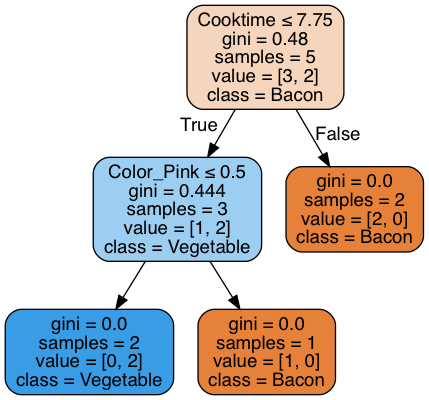

In [21]:
dot_data = StringIO()  

export_graphviz(
    model, 
    out_file = dot_data,  
    filled=True, rounded=True, proportion=False,
    special_characters=True, 
    feature_names=food_encoded.columns,
    class_names=["Bacon", "Vegetable"]
)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())  

## What's happening with our decision tree?

We can validate each step by looking at the various aspects of our data, calculated by the decision tree model, represented by the graph figure.


### What does this really mean?
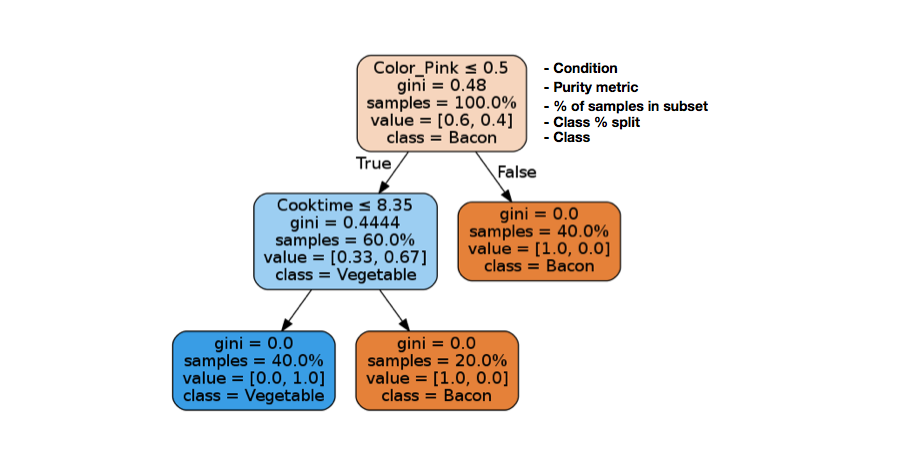

- **Root node** - Color != "Pink" (remember it's encoded as 1 or 0 in a new column)
    - %40 Bacon (sent to right node, False)
    - %60 Vegatables (send to left node, True)
    
    
- **Split node**
    - `Cooktime <= 8.35` 
    - Of the %60 of this subsets data, there's a class balance of %66 (2/3) vegatables and %33(1/3) bacon 


- **Leaf nodes**
    - Gini score of 0.0, is considered "pure" because the node contains homogenous data.

## What do you think would happen if:
_Knowing what you know now._

- Set the max depth that a tree was allowed to become?
- What if we let our tree grow to max depth?

<a id='overfit'></a>
## Addressing overfitting

---

A stopping criterion determines when to no longer construct further nodes. 

We can stop when all records belong to the same class, or when all records have the same attributes. This *maximizes variance at the expense of bias*, leading to overfitting. 

**Setting a maximum depth:**

A simple way to prevent overfitting is to set a hard limit on the "depth" of the decision tree.

**Minimum observations to make a split:**

An alternative to maximum depth (and can be used at the same time), is to specify the minimum number of datapoints reqired to make a split at a node.


<a id='advantages'></a>
## CART advantages
---

- Simple to understand and interpret. People are able to understand decision tree models after a brief explanation.
    - Useful to work with non technical departments (marketing/sales).
- Requires little data preparation. 
    - Other techniques often require data normalization, dummy variables need to be created and blank values to be removed.
- Able to handle both numerical and categorical data. 
    - Other techniques are usually specialized in analyzing datasets that have only one type of variable.
- Uses a **white box** model.
    - If a given situation is observable in a model the explanation for the condition is easily explained by boolean logic.
    - By contrast, in a **black box** model, the explanation for the results is typically difficult to understand, for example in neural networks.
- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.
- Robust. Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.
- Performs well with large datasets. Large amounts of data can be analyzed using standard computing resources in reasonable time.
- Once trained can be implemented on hardware and has extremely fast execution.
    - Real-time applications like trading, for example.

<a id='disadvantages'></a>
## CART disadvantages
---

- Locally-optimal.
    - Practical decision-tree learning algorithms are based on heuristics such as the greedy algorithm where locally-optimal decisions are made at each node. 
    - Such algorithms cannot guarantee to return the globally-optimal decision tree.
- Overfitting.
    - Decision-tree learners can create over-complex trees (high variance) that do not generalize well from the training data.
- There are concepts that are hard to learn because decision trees do not express them easily, such as XOR, parity or multiplexer problems. In such cases, the decision tree becomes prohibitively large.
    - Neural networks, for example, are superior for these problems.
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

## Independent Practice (time permitting)


Load up the Titanic dataset and fit a logistic regression model and a decisionn tree model.  Explore the hyperparameters of the DecisionTreeClassifier to explore the idea of overfitting and how decision tree hyperparameter affect classification metrics.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [24]:
titanic = pd.read_csv("titanic_clean.csv")
features = ["Pclass", "Age", "SibSp", "Sex", "Embarked"]

# Encode your design matrix here
titanic_encoded = pd.get_dummies(titanic[features])

### 1. LogisticRegression vs DecisionTree

Fit a model for both LogisticRegression and DecisionTreeClassifier.  How do they compare with no tuning?

### 2. Cross-validate on a DecisionTreeClassifier with 70/30 tain/test.

Which of these parameters has the biggest impact on overfitting:

- max_depth
- min_samples_split
- samples_leaf

> You might find it useful to plot a range of these values manually, or using a GridSearch.

In [25]:
## One consideration:  Is your model's performance on its own training set much better than on its held-out validation set?
tree = DecisionTreeClassifier(max_depth=None, min_samples_split=3, min_samples_leaf=1)
tree.fit(titanic_encoded, titanic['Survived'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### 3. Which hyperparameters have the biggest impact on precision and recall:

- max_depth
- min_samples_split
- samples_leaf

> You might find it useful to plot a range of these values to a train / test manually, or using a GridSearch.
> ie:  `for max_depth in range(0, 10): ...`

In [21]:
from sklearn.metrics import precision_score, recall_score

# A: